In [188]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [189]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [190]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [191]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


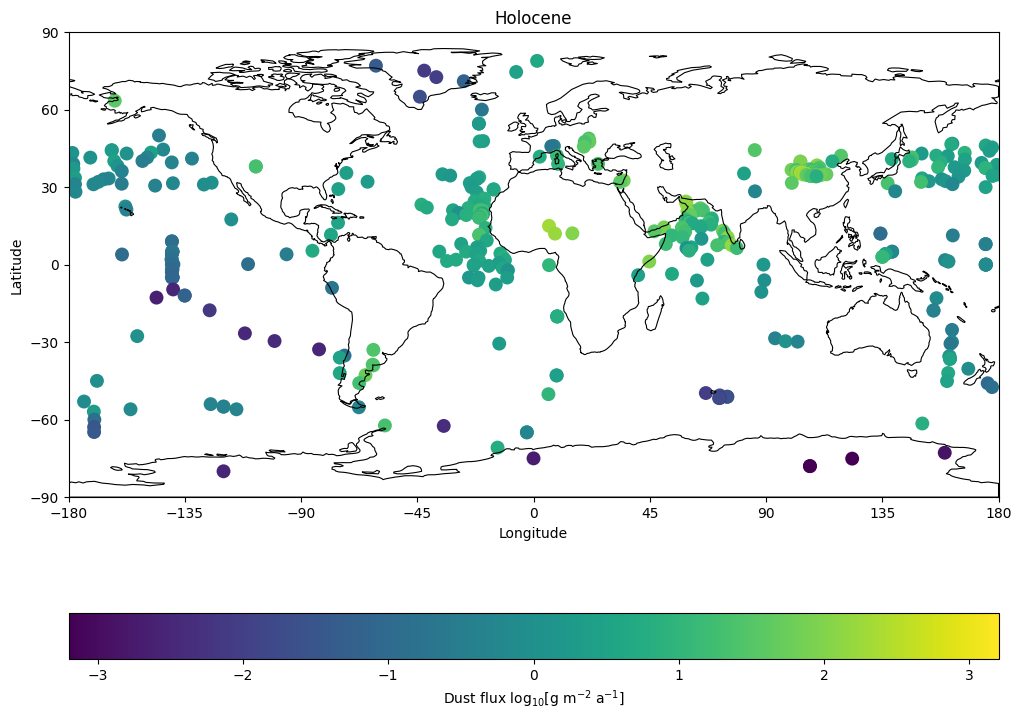

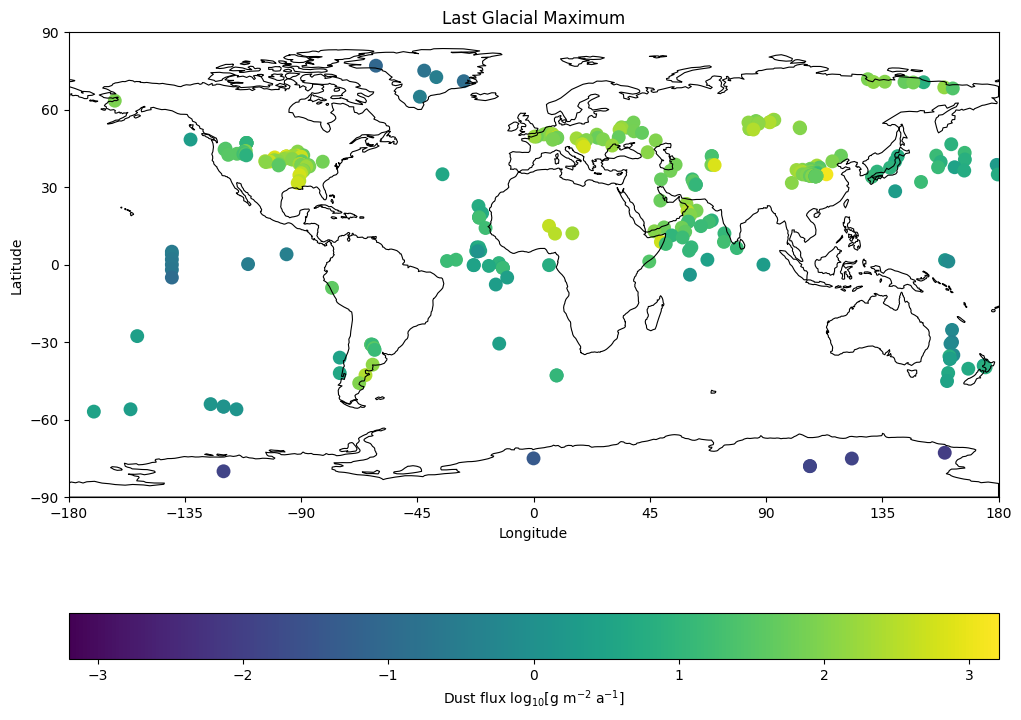

In [192]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [193]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

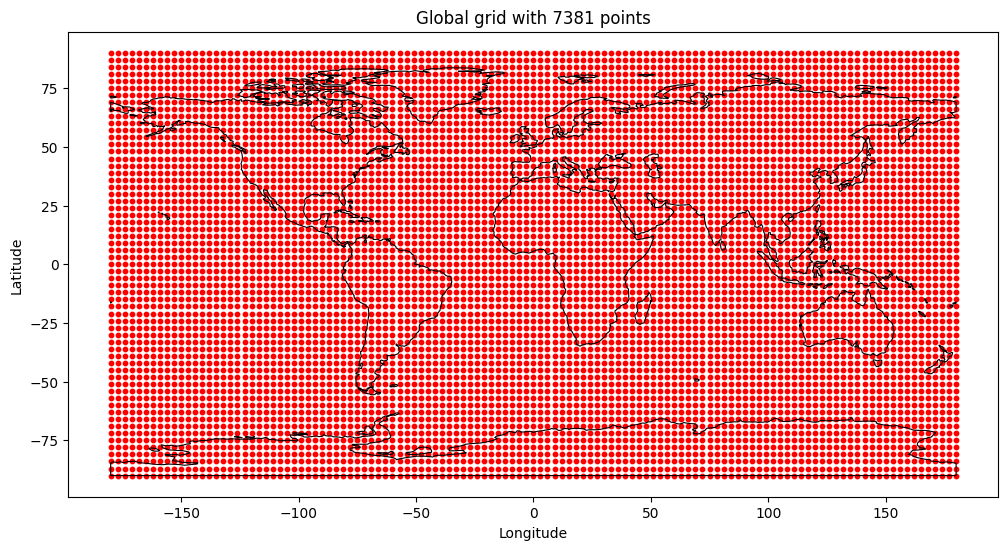

In [194]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [195]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [196]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
   
    lat1, lon1 = np.radians(x)
    lat2, lon2 = np.radians(y)
    
    R = 6371.0
    
    distance = np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon2 - lon1)) * R
    
    return distance

In [197]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [198]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [199]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

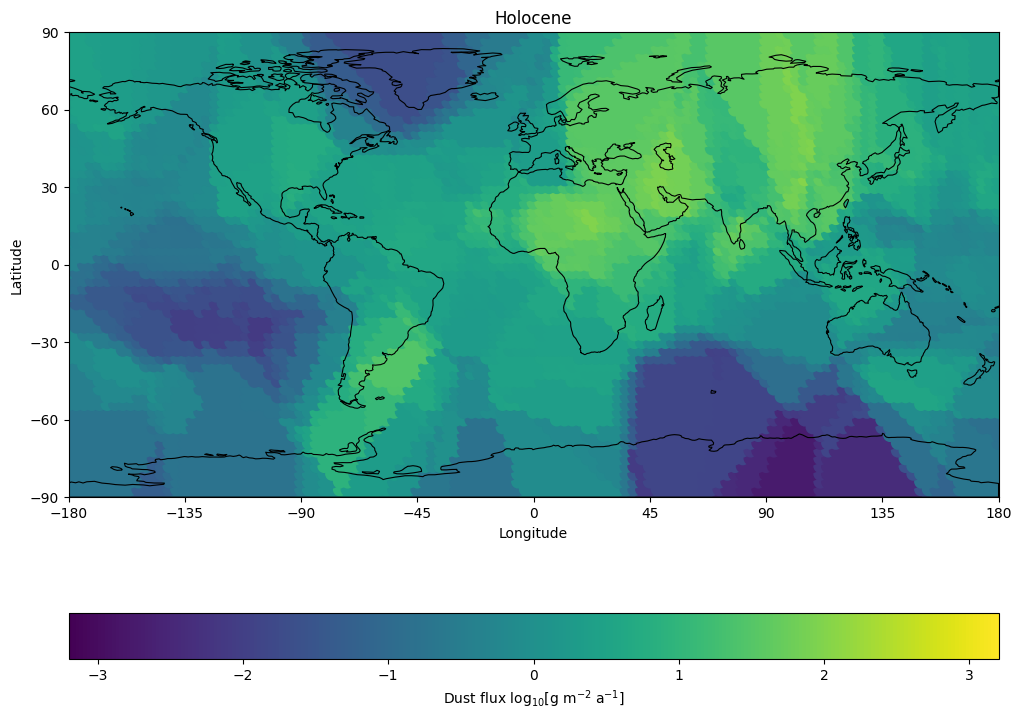

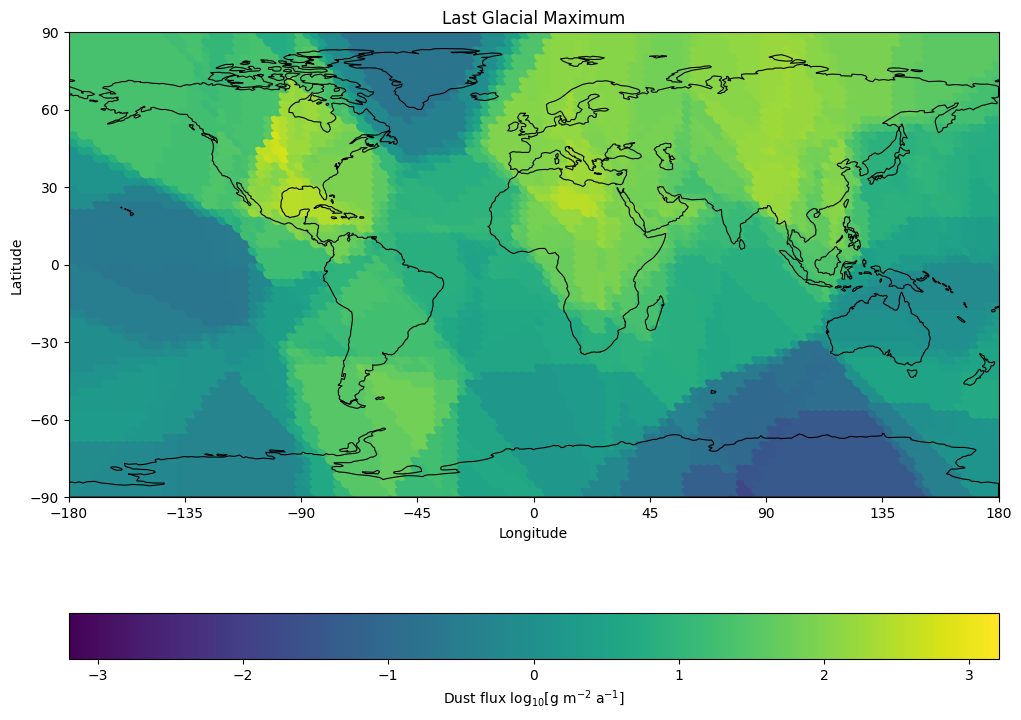

In [200]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

## Veamos los resultados utilizando la distancia geodésica


In [201]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geo"] = estimations_holocene
df_global_grid["est_lgm_geo"] = estimations_lgm

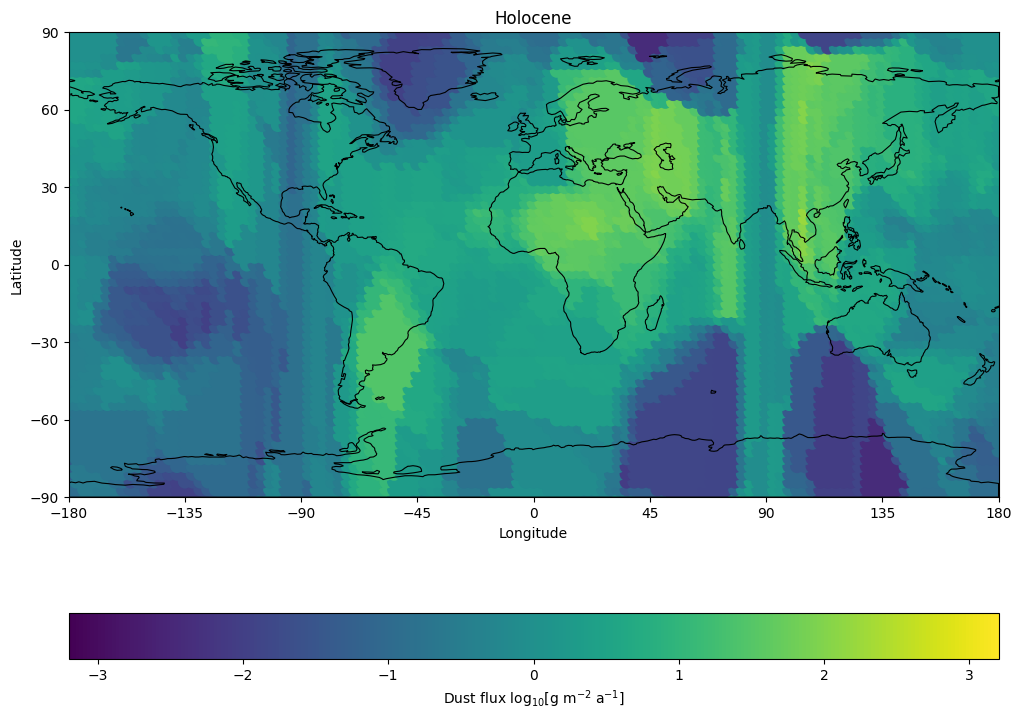

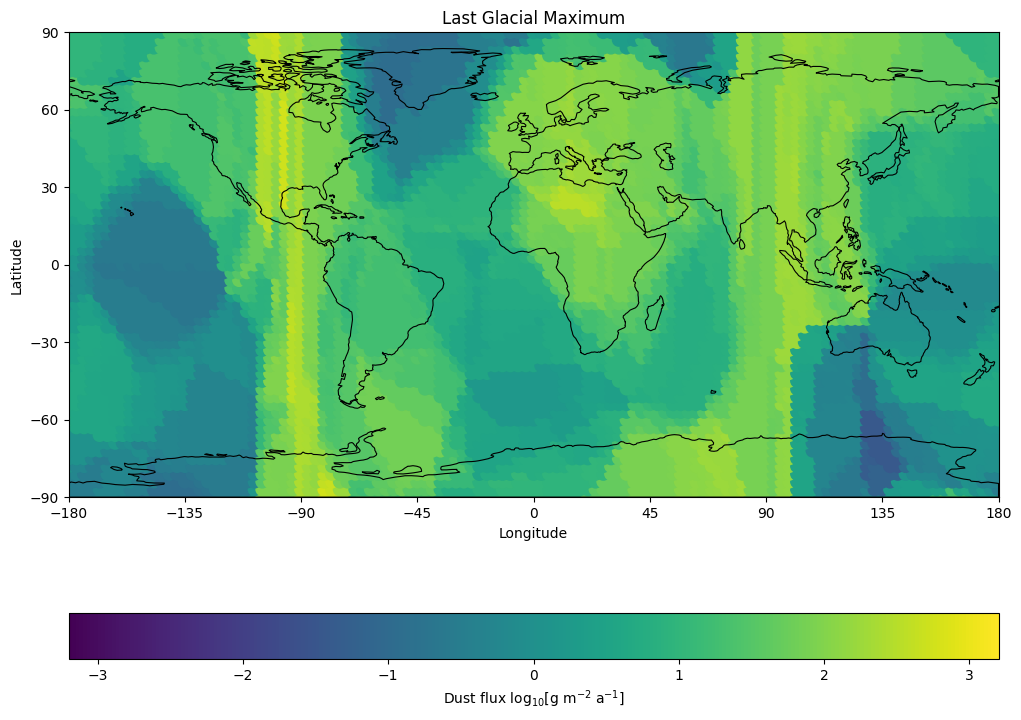

In [202]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_GEO',
                         label_str='est_hol_geo')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM_GEO',
                         label_str='est_lgm_geo')

## Analicemos la diferencia entre ambas

In [203]:
diferencia_holocene = df_global_grid['est_hol'] - df_global_grid['est_hol_geo']
diferencia_lgm = df_global_grid['est_lgm'] - df_global_grid['est_lgm_geo']


df_global_grid['diferencia_holocene'] = diferencia_holocene
df_global_grid['diferencia_lgm'] = diferencia_lgm


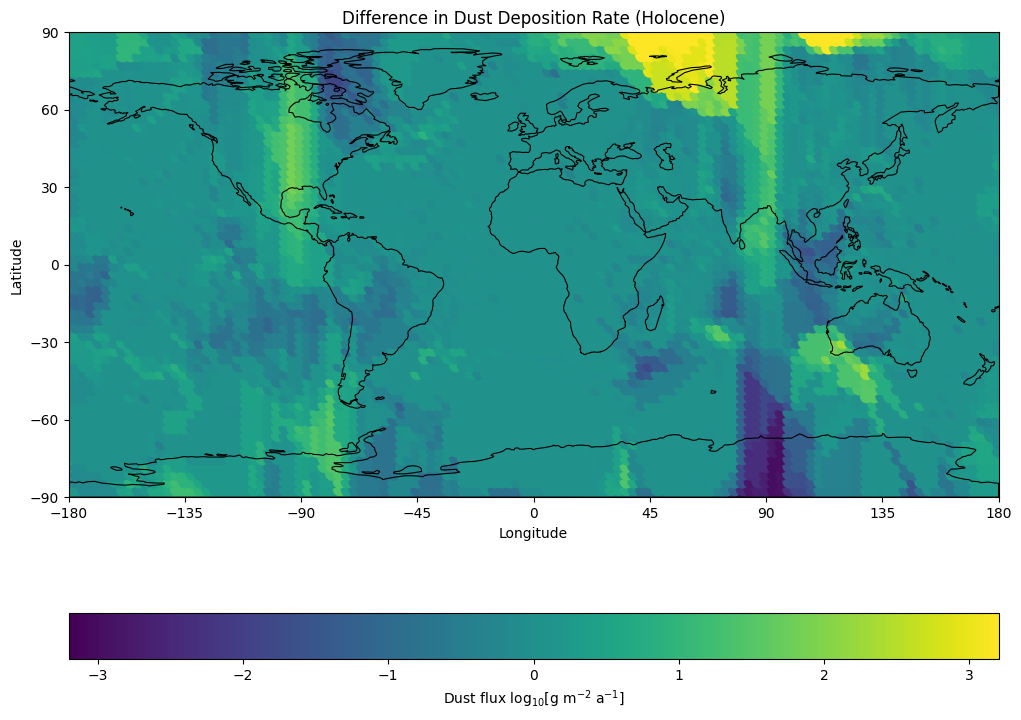

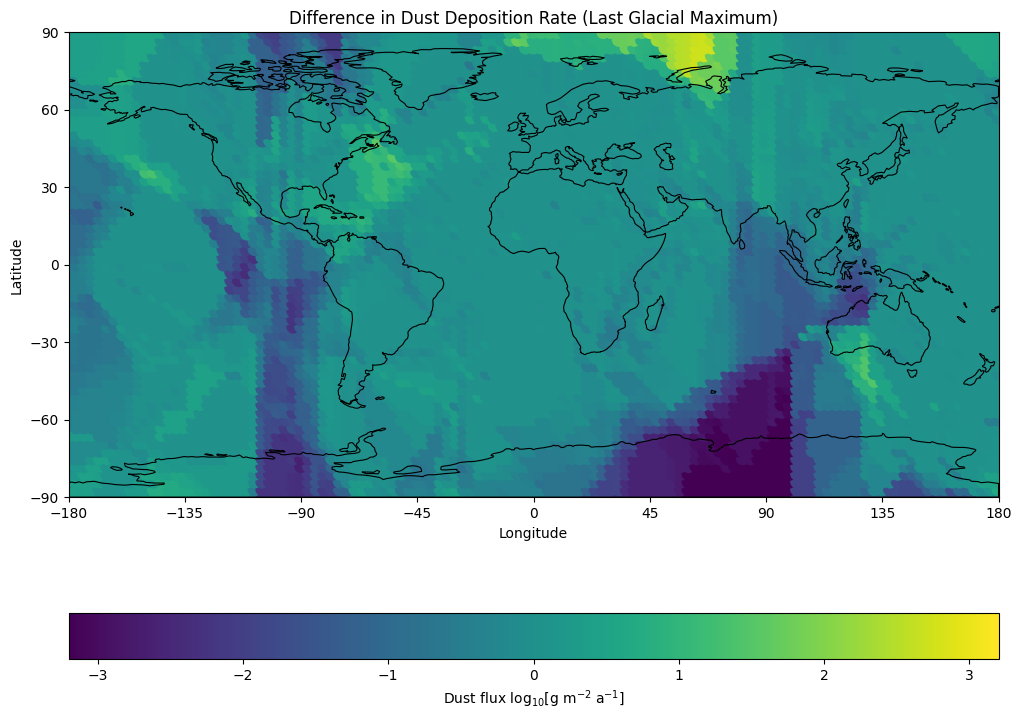

In [204]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Difference in Dust Deposition Rate (Holocene)',
                         name_to_save='DIFFERENCE_MAP_HOLOCENE',
                         label_str='diferencia_holocene')

plot_dust_deposition_map(df=df_global_grid,
                         title='Difference in Dust Deposition Rate (Last Glacial Maximum)',
                         name_to_save='DIFFERENCE_MAP_LGM',
                         label_str='diferencia_lgm')


#### ¿Por qué las diferencias son más grandes en una parte que otra parte del mundo?

Podemos notar que tanto en el LGM como en el Holoceno existe una gran diferencia, especialmente en zonas como el polo norte y sur, en la latitud 60-90 y en la longitud -90 ∧ 90. Estas diferencias pueden atribuirse a varios factores, tales como corrientes de viento en diferentes periodos climáticos, la circulación atmosférica, factores geográficos como la falta de vegetación, la altitud, las masas de agua, entre otros. Además, la falta de datos también puede contribuir significativamente a estas diferencias, ya que la disponibilidad y calidad de los datos pueden variar ampliamente según la ubicación geográfica y época. Esto puede resultar en una menor precisión en las estimaciones en áreas con una menor densidad de datos, lo que a su vez puede amplificar las diferencias entre los métodos geodésico y euclidiano.
#### ¿Cuál método es más fidedigno en los polos sur y norte?

Al comparar los mapas de distancias euclidianas y geodésicas, podemos concluir que la distancia geodésica suele ofrecer estimaciones más precisas en los polos sur y norte. Esto se debe a que, al tener en cuenta la curvatura de la Tierra, la distancia geodésica muestra una mayor cantidad de polvo en estas regiones extremas como podemos ver en el mapa. Por el contrario, la distancia euclidiana tiende a proporcionar estimaciones menos precisas en estas áreas, ya que intenta representar una superficie curva en un plano, lo que puede ocasionar distorsiones en las mediciones.

#### ¿Cuál método es más fidedigno en longitud 180°?

Podemos notar en los mapas de las diferencias de ambos periodos que la diferencia en la longitud 180° entre el metodo euclidiano y el geodésico es casi nula, por ende podemos decir que no hay un metodo mas fidedigno que el otro en esta longitud.

#### ¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?

Las diferencias entre los resultados para el Holoceno y el LGM son más notables al utilizar el método geodésico en lugar del euclidiano. En primer lugar, se observa que la cantidad de polvo es considerablemente mayor durante el periodo LGM en comparación con el Holoceno. Además, este método revela cantidades de polvo que no eran evidentes con el método euclidiano. Estas diferencias son especialmente pronunciadas en los polos norte y sur. También se observa una concentración pronunciada de datos, representada por una línea vertical gruesa en el mapa, especialmente en las longitudes -90 y 90. Estos hallazgos sugieren una distribución más precisa del polvo en la superficie terrestre durante el LGM y el Holoceno.


#### ¿Cómo elegir el número de vecinos cercanos?

El número de vecinos cercanos (n_neighbours) deberiamos elegirlos en base a la distancia entre los puntos que tenemos, en nuestro caso tenemos zonas con varios datos agrupados y otros con escasez como por ejemplo el oceano, por ende seria util elegir un numero de vecinos cercanos "medio", en este caso me parecio correcto que el "k" sea 4, 5 o 6. Al ajustar este parámetro según la distancia y densidad de los datos, podemos obtener estimaciones más precisas en áreas con poca información.

#### Referencias

Se utilizó ChatGPT a la hora de interpretar el codigo y redacción.

Gili, S., Vanderstraeten, A., Chaput, A. et al. South African dust contribution to the high southern latitudes and East Antarctica during interglacial stages. Commun Earth Environ 3, 129 (2022). https://doi.org/10.1038/s43247-022-00464-z

https://www.linkedin.com/pulse/revisando-conceptos-de-aprendizaje-supervisado-y-arag%C3%B3n-matute/